# Predicting home prices in Ames, IA

The purpose of this notebook is for me to learn something about Python programming, how to process data using Python, and how to perform machine learning tasks in Python. It may perhaps also provide some decent predictions of house prices in Ames, IA.

This data holds quite a bit of interest for me, because my wife and I are currently going through the process on both sides of the table - we've put our current house on the market, and we have a new house under contract.

I'd also like to invite anyone who takes the time to read this to point out ways in which my methods or code could be better, as I'm still figuring all this out. Also, **this is a work in progress**, so it will have many updates.

## 1 Import libraries

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.ticker as tick
import seaborn as sb
import graphviz
from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

ImportError: No module named 'graphviz'

## 2 Read in the data

In [2]:
train = pd.read_csv("./Data/train.csv", header=0)
test = pd.read_csv("./Data/test.csv", header=0)

In [3]:
train.head(3)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  

[3 rows x 81 columns]

## 3 Data cleaning
Let's check to what extent we need to clean up the data before throwing a model at it. On a previous version I had my own definition of these, but the results ended up being terrible, so I shamelessly stole large portions from [this kernel](https://www.kaggle.com/mountaindata/house-prices-advanced-regression-techniques/house-price-regression).

### 3.1 Get rid of NaNs
It looks like several columns have a lot of missing values. From the data dictionary provided, it seems that this should be expected. These should be interpreted as the absence of a given feature rather than a missing value. However, we're going to have to do something with them, because scikit-learn doesn't like them. We'll convert them to 0s.

In [4]:
train = train.fillna(0)
test = test.fillna(0)

### 3.2 Separating types of features
We want to get lists of all the features - one grand list, and also separate lists for categorical and numerical features. The former we will convert to Pandas's category type, and the latter we will leave alone. We won't carry the Id column (which is useless except as an identifier) and the sale price (the target). The middle set I've identified as "ordered categories", and I'll code them myself in what I feel is a natural way.

In [5]:
features = [x for x in train.columns if x not in ['id','SalePrice']]

In [6]:
cat_features = ['MSSubClass', 'MSZoning', 'Street','Alley', 
'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
'HouseStyle','OverallQual','OverallCond',
'Foundation', 'BsmtFinType1','BsmtFinType2', 
'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType',
'Heating','CentralAir','Electrical','BsmtFullBath',
'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
'TotRmsAbvGrd','Functional','Fireplaces','GarageType',
'GarageFinish','GarageCars','PavedDrive',
'Fence','MiscFeature','SaleType','SaleCondition']

In [7]:
ord_cat_features = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',
                   'HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC']

In [8]:
num_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
'BsmtUnfSF','TotalBsmtSF', 'LowQualFinSF','1stFlrSF','2ndFlrSF',
'GrLivArea', 'YearRemodAdd', 'YearBuilt','GarageYrBlt','GarageArea','WoodDeckSF',
'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']

### 3.3 Converting categorical values to numeric values
We need to get rid of all the string values and replace them with numeric values. For this we'll lean on Pandas's categorical type, which didn't exist the last time I messed with Python extensively. They're a bit like R's "factors", which come in handy.

In [9]:
rows_train = len(train)
rows_test = len(test)

We'll now glue the training and test set together, for all but the sale price, which the test set doesn't have in this case. Later, we'll split them back apart. We do this because the test data might have instances within a category not seen in the test data, in which case Pandas won't pick them up. For example, if there are no values of 'I' in the 'MSZoning' field in the training data but not the test data, they'll be ignored when we convert the categories to codes. Gluing the datasets together prevents this. It wouldn't help at all if you had to run the model against data you didn't have access to (which is a possibility in this case).

Another thing that annoys me is that some of these categoricals could justifiably be considered to be ordered, in which case I want the order to be preserved. Pandas won't figure this out automatically. Some are easy, like OverallQual - which is already numbered from 1-10. Nothing more needs to be done. Others have 'excellent', 'good', etc., and we'd like these to mean something as well.

For predictions - it may not matter - it's possible to just assign a number to each category, regardless of order, and move along our merry ways. However, it's important in business to be able to interpret and explain model results, and you might not get to be there to walk through your arbitrary encoding scheme with The Powers That Be(tm).

In [10]:
code_scheme = []
# glue data sets together
train_test = pd.concat((train[features], test[features])).reset_index(drop=True)
# Convert categoricals to codes
for c in range(len(cat_features)):
    cat = train_test[cat_features[c]].astype('category')
    coding = (cat_features[c], dict(enumerate(cat.cat.categories)))
    code_scheme.append(coding)
    train_test[cat_features[c]] = cat.cat.codes
# The result is that each column is replaced by its category code, and I get an array of 2-tuples - the first element
# is the feature being encoded, and the second is a dict containing the encoding

First the coding helper function, stolen from [here](https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/)

In [11]:
#Define a generic function using Pandas replace function
def coding(col, codeDict):
  colCoded = pd.Series(col, copy=True)
  for key, value in codeDict.items():
    colCoded.replace(key, value, inplace=True)
  return colCoded

Now the coding:

In [12]:
train_test['ExterQual'] = coding(train_test['ExterQual'], {'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1})
train_test['ExterCond'] = coding(train_test['ExterCond'], {'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1})
train_test['BsmtQual'] = coding(train_test['BsmtQual'], {'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1, 0:0})
train_test['BsmtCond'] = coding(train_test['BsmtCond'], {'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1, 0:0})
train_test['BsmtExposure'] = coding(train_test['BsmtExposure'], {'Gd':4,'Av':3,'Mn':2,'No':1, 0:0})

In [13]:
train_test['HeatingQC'] = coding(train_test['HeatingQC'], {'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1})
train_test['KitchenQual'] = coding(train_test['KitchenQual'], {'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1})
train_test['FireplaceQu'] = coding(train_test['FireplaceQu'], {'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1, 0:0})
train_test['GarageQual'] = coding(train_test['GarageQual'], {'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1, 0:0})
train_test['GarageCond'] = coding(train_test['GarageCond'], {'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1, 0:0})
train_test['PoolQC'] = coding(train_test['PoolQC'], {'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1, 0:0})

### 3.4 Restore training and test sets
I keep forgetting about iloc. It makes cutting up Pandas DataFrames work kind of like dataframes in R do. We'll put the training and test sets back in the same boxes as before.

In [14]:
trainX = train_test.iloc[:rows_train,:]
testX = train_test.iloc[rows_train:,:]

## 4 Data exploration
Now it's time to look at the data and see what, if anything, looks weird or notable.

### 4.1 Distribution of target variable
Let's look at the distribution of the target variable to see if we need to adjust it. Since RMSE of the logs is the standard by which we'll be measured, we'll probably have to log-transform the sale prices.

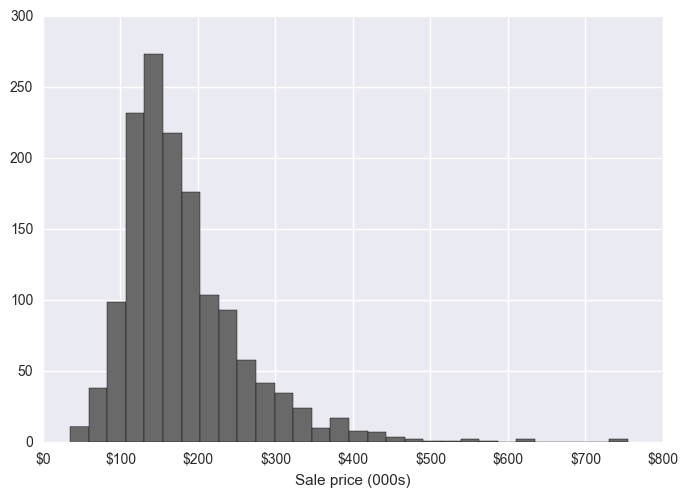

In [15]:
fig = plt.figure()
ax = plt.axes()
n,bins,patches=plt.hist(train['SalePrice'], 30, facecolor='dimgrey')
plt.xlabel("Sale price (000s)")
vals=ax.get_xticks()
ax.set_xticklabels(['${:,.0f}'.format(x/1000) for x in vals])
plt.show()

In [16]:
target = np.log(train['SalePrice'])

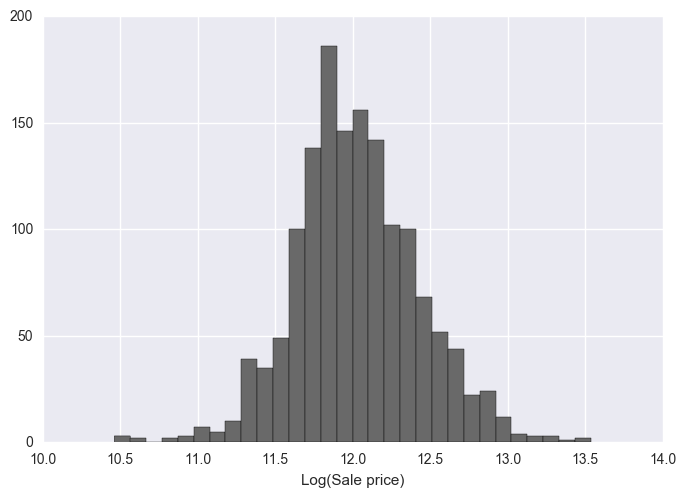

In [17]:
fig = plt.figure()
ax = plt.axes()
n,bins,patches=plt.hist(target, 30, facecolor='dimgrey')
plt.xlabel("Log(Sale price)")
plt.show()

That makes the sale prices look more normally distributed, so it might behave more amenably to models

### 4.2 Exploring categorical features
Let's take a look at the categorical features. First, a helper function to enable my laziness.

In [18]:
def doPlots(x, data, ii, fun):
    fig, axes = plt.subplots(len(ii) // 2, ncols = 2)
    fig.tight_layout()
    for i in range(len(ii)):
        fun(x=x[ii[i]], data=data, ax=axes[i // 2, i % 2], color='dimgrey')
    plt.show()

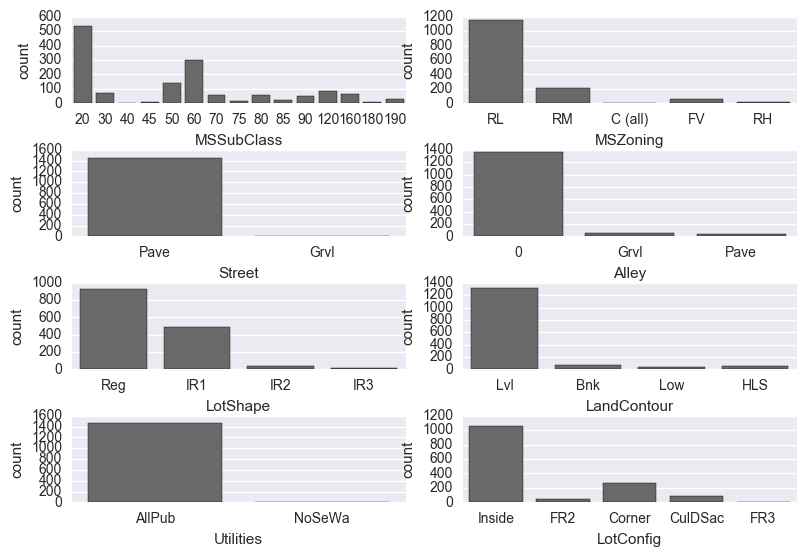

In [19]:
doPlots(cat_features, train, range(0,8), sb.countplot)

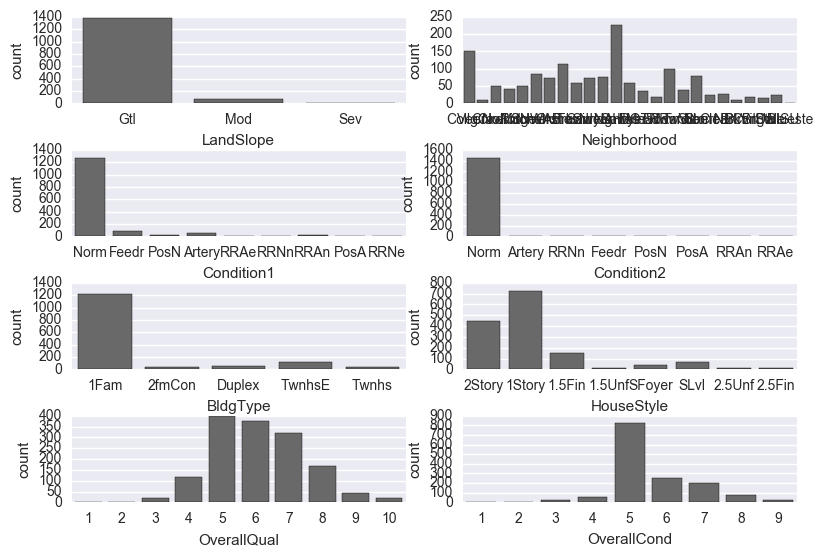

In [20]:
doPlots(cat_features, train, range(8,16), sb.countplot)

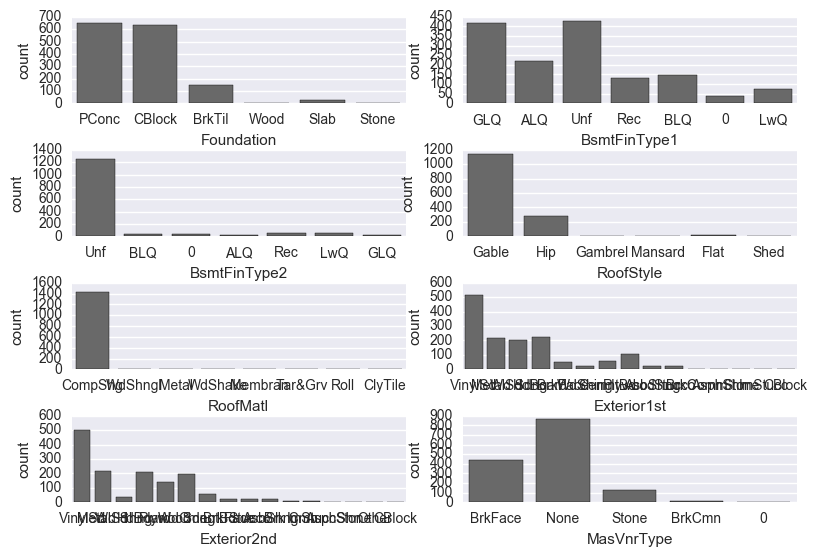

In [21]:
doPlots(cat_features, train, range(16,24), sb.countplot)

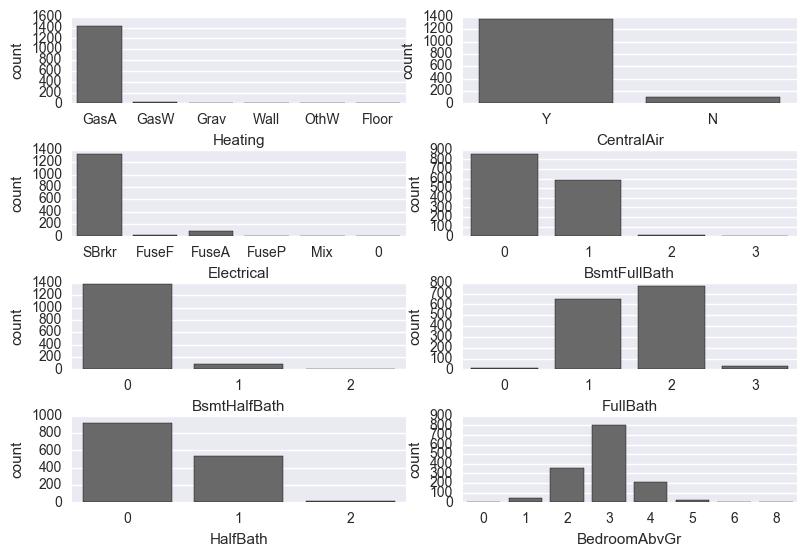

In [22]:
doPlots(cat_features, train, range(24,32), sb.countplot)

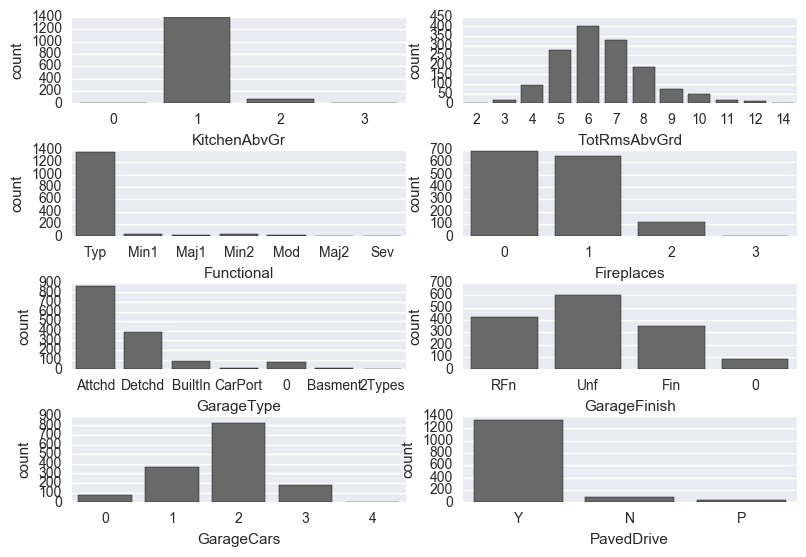

In [23]:
doPlots(cat_features, train, range(32,40), sb.countplot)

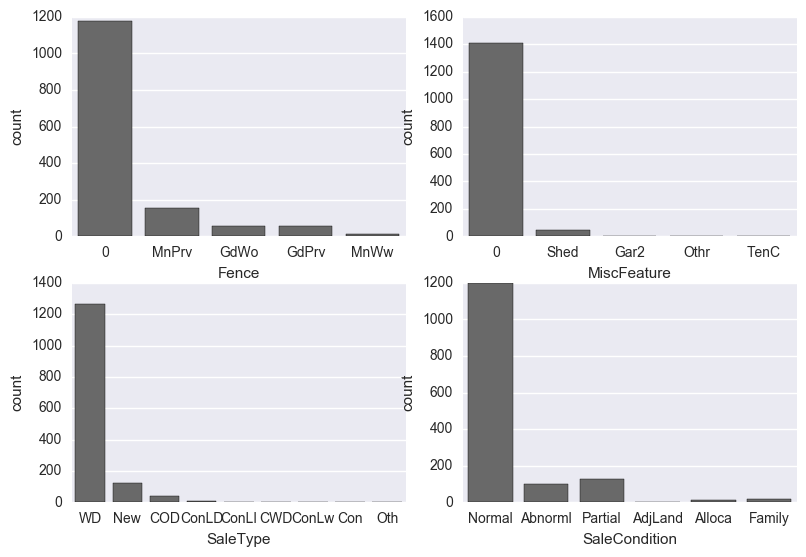

In [24]:
doPlots(cat_features, train, range(40,44), sb.countplot)

**Observations:**

* Most houses have been built since 1946. That makes sense - as that corresponds with the beginning of the post-war housing boom in the Midwest.
* Almost all are zoned for residential, are on paved streets, and do not have access to an alley.
* Most are on regular or slightly irregular lots (although degrees of irregularity aren't defined).
* Most are on level ground and have access to all public utilities.
* Few were on cul-de-sacs.
* Very few were close to arterial or feeder streets, which seems surprising.
* Almost all are single family homes of one or two stories. 
* I assume the overall quality and condition assessments were subjective. If so, people seemed a lot more ambivalent about house condition than materials quality.
* Most houses had either poured concrete or cinder block foundations. I feel like every cinder block or brick foundation I've ever seen has been associated with leaking or buckling. My wife observed that these are associated with older houses, and may actually be better because they shift with the earth, whereas concrete foundations just crack. Furthermore, the latter tend to be older than the former:

In [25]:
np.average(train['YearBuilt'][train['Foundation']=='PConc'])

1993.3075734157651

In [26]:
np.average(train['YearBuilt'][train['Foundation']=='CBlock'])

1961.2539432176657

### 4.3 Exploring numeric features
Let's look at histograms of the numerical features to see what we can see.

In [27]:
def doHistPlots(x, data, ii, fun):
    fig, axes = plt.subplots(len(ii) // 2, ncols = 2)
    fig.tight_layout()
    for i in range(len(ii)):
        fun(data[x[ii[i]]], color='b', ax=axes[i // 2, i % 2], kde=False)
    plt.show()

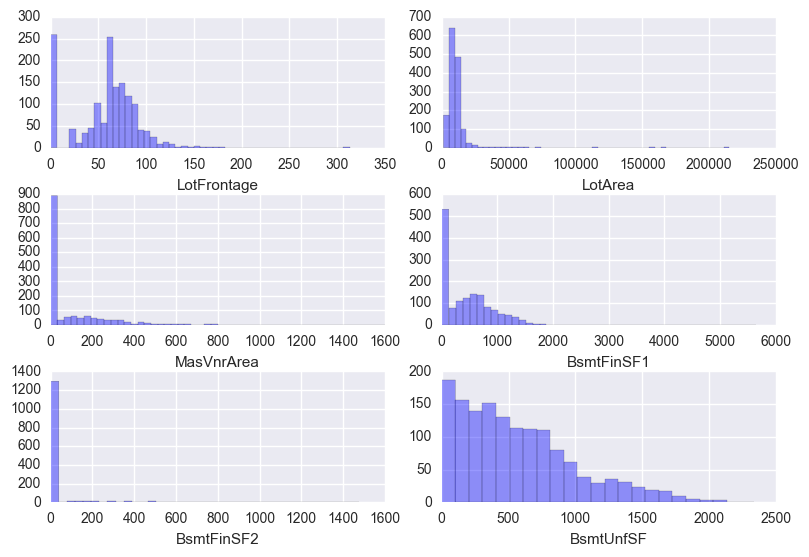

In [28]:
doHistPlots(x=num_features, data=train, ii=range(0,6), fun=sb.distplot)

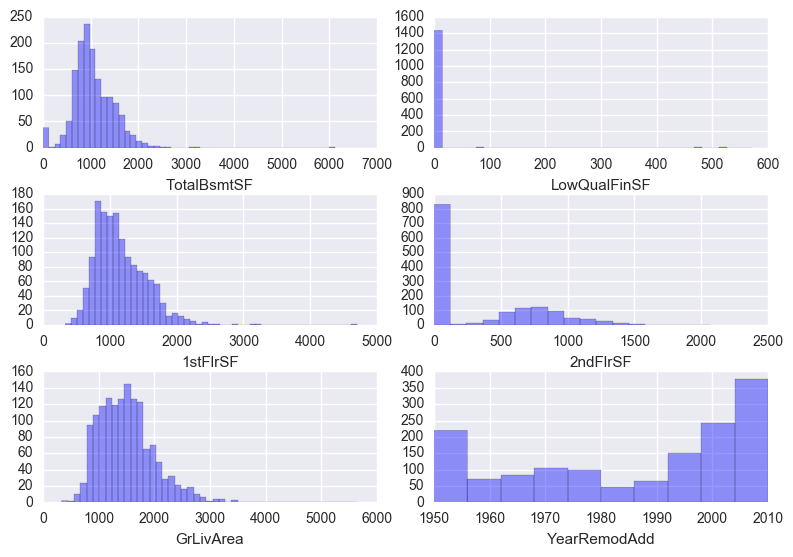

In [29]:
doHistPlots(x=num_features, data=train, ii=range(6,12), fun=sb.distplot)

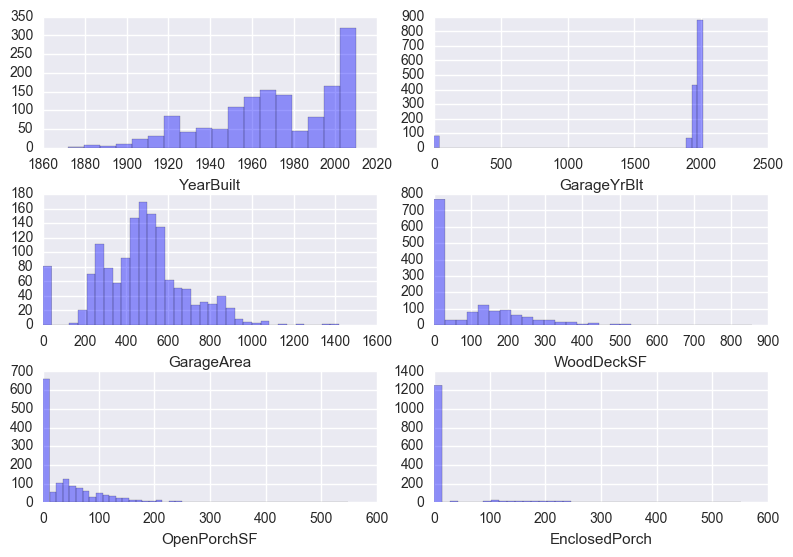

In [30]:
doHistPlots(x=num_features, data=train, ii=range(12,18), fun=sb.distplot)

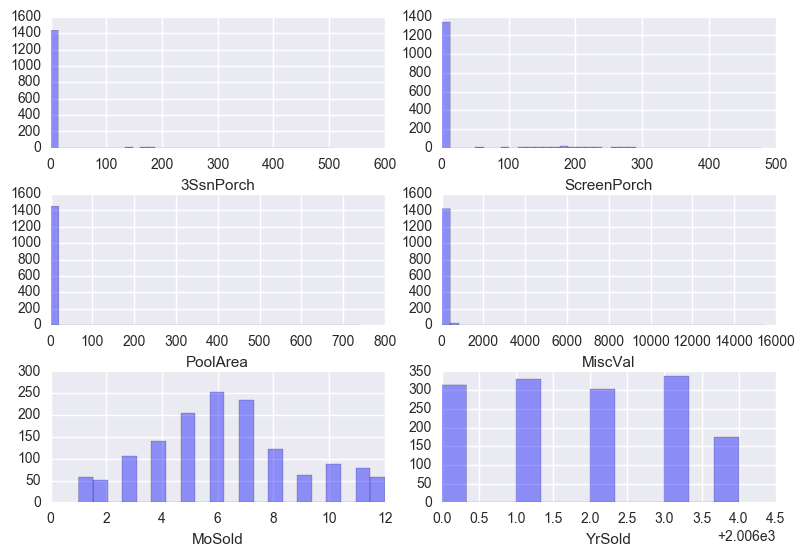

In [31]:
doHistPlots(x=num_features, data=train, ii=range(18,24), fun=sb.distplot)

**Observations:**
* There are a small number of houses with humongous (by comparison) lots. Similarly, there appears to be a house with a 6,000 square foot basement.
* There are houses with a lot frontage / area of 0, which makes no sense.
* Other than the month of sale, ages, and sizes, none of these look very useful.

In [32]:
train[train['TotalBsmtSF']>4000]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1298  1299          60       RL        313.0    63887   Pave     0      IR3   

     LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature  \
1298         Bnk    AllPub    ...          480     Gd     0           0   

     MiscVal MoSold YrSold  SaleType  SaleCondition  SalePrice  
1298       0      1   2008       New        Partial     160000  

[1 rows x 81 columns]

In [33]:
print(train['TotalBsmtSF'].iloc[1298,])
print(train['GrLivArea'].iloc[1298,])
print(train['OverallCond'].iloc[1298,])
print(train['OverallQual'].iloc[1298,])

6110
5642
5
10


So, that's a really big house that sold for $160,000, was a 10 in quality, has a 480 square foot pool, and was a 5 in condition. And it's a football field's distance from the street. That looks weird, so we're just going to cut that one out of the training set.

In [34]:
trainX = trainX.drop(train.index[[1298]])

## 5 Modeling
Now let's throw some models at what we've got and see how we do.

### 5.1 Features to use
Let's select the features we're going to use. There were a couple of columns I wanted to look at in more detail.

**Neigborhood:** There are quite a few neighborhoods. Surely these can be reduced to a few classes.

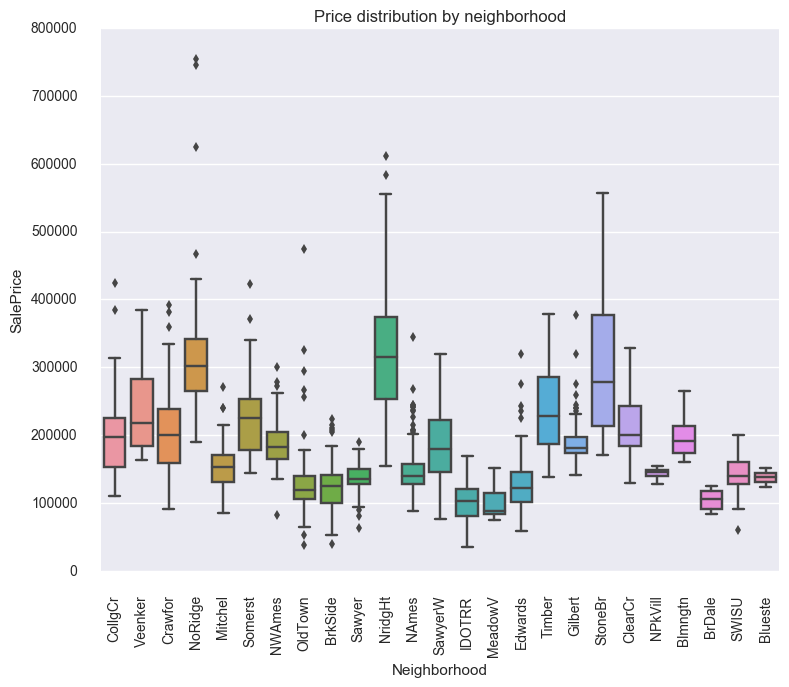

In [35]:
plt.rcParams['figure.figsize'] = (8.75, 7.0)
ax = plt.axes()
plot1 = sb.boxplot(data=train, x='Neighborhood', y='SalePrice')
ax.set_title("Price distribution by neighborhood")
sb.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.show()

Only one has a median sale price clearly below \$100,000. It looks like there is another class with medians between \$100k and \$150k, another class with medians between \$150k and \$200k, one for medians between \$200k and \$250k, and finally a class for medians above \$250k.

In [36]:
def transform_nb(x):
    if x in ("NoRidge", "NridgHt", "StoneBr"):
        return 5 #Over 250
    elif x in ('CollgCr','Veenker','Crawfor','Somerst','Timber','ClearCr'):
        return 4 #200-250
    elif x in ('Mitchel','NWAmes','SawyerW','Gilbert','Blmngtn','SWISU', 'Blueste'):
        return 3 #150-200
    elif x in ('OldTown','BrkSide','Sawyer','NAmes','IDOTRR','Edwards','BrDale', 'NPkVill'):
        return 2 #100 - 150
    elif x in ('MeadowV'):
        return 1
    else:
        return 9 # Catch mistakes

In [37]:
train['NbdClass'] = train['Neighborhood'].apply(transform_nb)

In [38]:
test['NbdClass'] = test['Neighborhood'].apply(transform_nb)

In [39]:
trainX['NbdClass'] = train['NbdClass']

In [40]:
# This is messed up and gives a warning, I couldn't figure out how to make it go away
z = test.loc[:,'NbdClass']
z=np.asarray(z)
testX.loc[:,'NbdClass'] = z

C:\Users\Jason\Anaconda3\lib\site-packages\pandas\core\indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Jason\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Let's redo the sale price plot with our new class and see how it comes out.

In [41]:
trainX[trainX['NbdClass']==9]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, NbdClass]
Index: []

[0 rows x 81 columns]

In [42]:
train.loc[126, 'Neighborhood']

'NPkVill'

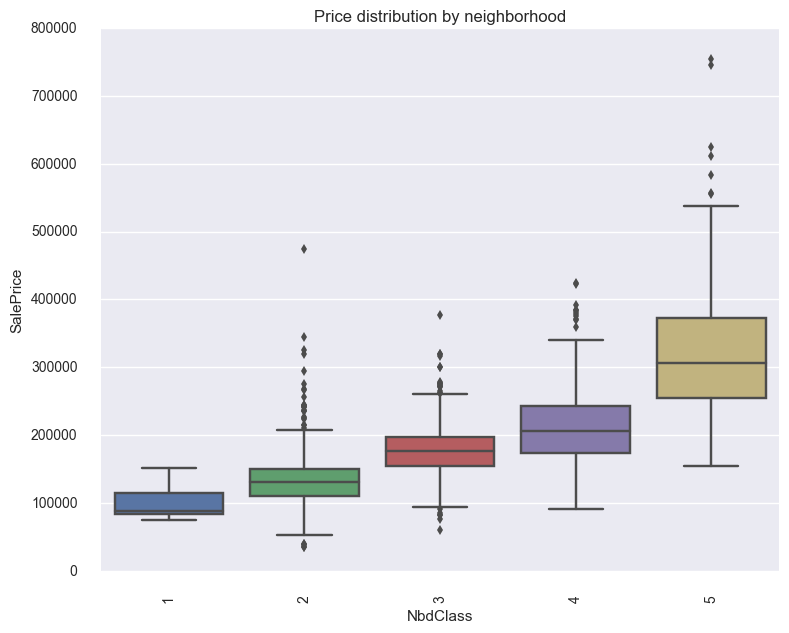

In [43]:
plt.rcParams['figure.figsize'] = (8.75, 7.0)
ax = plt.axes()
plot1 = sb.boxplot(data=train, x='NbdClass', y='SalePrice')
ax.set_title("Price distribution by neighborhood")
sb.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.show()

That looks halfway decent. Now let's make a list of features to use.

In [44]:
use_features = ['OverallQual','YearBuilt','YearRemodAdd','MasVnrArea','GrLivArea','TotalBsmtSF','FullBath','Fireplaces',
           'GarageYrBlt','GarageCars','NbdClass','HouseStyle','Alley','LotShape','LotConfig','Exterior1st',
           'Exterior2nd','ExterQual','ExterCond','Foundation','BsmtExposure','BsmtFinType1','HeatingQC','CentralAir',
           'FireplaceQu','GarageType','GarageFinish']

### 5.2 Lasso

In [45]:
# Test shrinkage parameters in cross-validation
alphas = np.logspace(-10,-1,num=20)

In [46]:
trainY = train['SalePrice']
trainY = trainY.drop(train.index[[1298]])
target = np.log(trainY)

In [47]:
lasso = linear_model.LassoCV(alphas=alphas, tol=0.0001, selection='random', random_state=17, max_iter=1000)
lasso.fit(trainX[use_features], target)

LassoCV(alphas=array([  1.00000e-10,   2.97635e-10,   8.85867e-10,   2.63665e-09,
         7.84760e-09,   2.33572e-08,   6.95193e-08,   2.06914e-07,
         6.15848e-07,   1.83298e-06,   5.45559e-06,   1.62378e-05,
         4.83293e-05,   1.43845e-04,   4.28133e-04,   1.27427e-03,
         3.79269e-03,   1.12884e-02,   3.35982e-02,   1.00000e-01]),
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=17, selection='random', tol=0.0001,
    verbose=False)

In [48]:
print("Best alpha is",lasso.alpha_)

Best alpha is 0.000143844988829


In [49]:
lasso.pred = lasso.predict(trainX[use_features])
print("Competition training RMSE:", np.sqrt(np.sum(lasso.pred - target)**2))

Competition training RMSE: 1.07647224468e-12


In [50]:
indices = np.arange(len(trainX[use_features].columns))
indices_nz = np.nonzero(lasso.coef_)
indices_z = np.setdiff1d(indices, indices_nz)
set([use_features[i] for i in indices_z])

set()

In [51]:
len(lasso.coef_)

27

In [52]:
len(use_features)

27

Whoops - It didn't really reduce any from the ones I selected. Well, let's try it anyway and see how it comes out. 

In [53]:
# see most important and least important features
tmp = [use_features[i] for i in indices_nz[0]]
tmp = np.array(tmp)
tmp2 = lasso.coef_[lasso.coef_ != 0]
lasso.c = pd.DataFrame({'cols':tmp, 'coefs':tmp2})

In [54]:
lasso.c = lasso.c.sort_values(by='coefs',ascending=False)

In [55]:
lasso.c[:5]

coefs         cols
23  0.124919   CentralAir
0   0.063575  OverallQual
10  0.055663     NbdClass
9   0.044524   GarageCars
18  0.034005    ExterCond

In [56]:
lasso.c[-5:]

coefs          cols
15 -0.006103   Exterior1st
13 -0.006289      LotShape
6  -0.011856      FullBath
26 -0.014793  GarageFinish
21 -0.016009  BsmtFinType1

In [57]:
sollasso = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.exp(lasso.predict(testX[use_features]))})

In [58]:
sollasso.to_csv("./Data/sollasso2.csv", index=False)

**Result:** This got a score of 0.14521, good enough for 2,017th place at the time of this writing. I'd like to try to beat that if I can.

### 5.3 Random forest
I'm going to do 10-fold cross-validation to select the best number of trees and depth of each tree in the forest.

In [59]:
ntrees = np.arange(100,1001,100)
depths = np.arange(1,8)

In [60]:
# Warning: This takes a bit
scores=[]
X = trainX[use_features]
Y = target
for n in ntrees:
    for d in depths:
        run_tot = 0
        for k in np.arange(0,10):
            
            # Get the kth fold of data
            testXcv = X[k*146:k*146+146]
            trainX_left = X[:k*146]
            trainX_right = X[k*146+146:]
            trainXcv = pd.concat([trainX_left, trainX_right])
            
            testYcv = Y[k*146:k*146+146]
            trainY_left = Y[:k*146]
            trainY_right = Y[k*146+146:]
            trainYcv = np.concatenate([trainY_left, trainY_right])
            
            # Fit a model and make predictions using the kth fold
            rf = RandomForestRegressor(n_estimators=n, max_depth=d, n_jobs=-1)
            rf.fit(trainXcv, trainYcv)
            preds = rf.predict(testXcv)
            
            # Add this fold's score to the previous ones
            run_tot = run_tot + np.sqrt(np.sum((preds - testYcv)**2))
            
        # Now we load the scores table with the parameters we're testing and the 10-fold average score
        scores.append({'ntrees':n, 'depth':d, 'score':run_tot/10.0})
        # Tell me where we're at - Comment this out if you find it annoying
    print("ntrees =",n)
scoredf = pd.DataFrame(scores)
print("Done!")

ntrees = 100
ntrees = 200
ntrees = 300
ntrees = 400
ntrees = 500
ntrees = 600
ntrees = 700
ntrees = 800
ntrees = 900
ntrees = 1000
Done!


Now, we'll plot our results. Number of trees will be along the x-axis, score along the y-axis, and the line color will be tied to the tree depth.

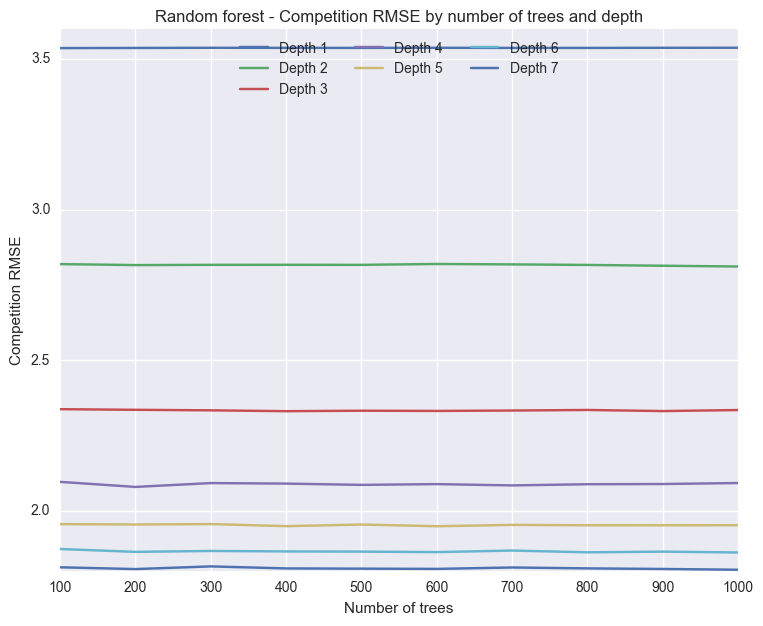

In [61]:
fig=plt.figure()
ax = plt.axes()
for d in depths:
    x = scoredf['ntrees'][scoredf['depth']==d]
    y = scoredf['score'][scoredf['depth']==d]
    plt.plot(x,y, label='Depth ' + str(d))
plt.legend(loc=9, ncol=len(depths)//2) # upper center
plt.xlabel("Number of trees")
plt.ylabel("Competition RMSE")
ax.set_title("Random forest - Competition RMSE by number of trees and depth")
plt.show()

Looks like depth 7 is a clear winner. But let's look at the value - it doesn't look like that great of a score:

In [62]:
scoredf[-1:]

depth  ntrees     score
69      7    1000  1.805241

In [63]:
rf_best = RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_depth=7, random_state=17)
rf_best.fit(trainX[use_features], target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False, random_state=17,
           verbose=0, warm_start=False)

One of the cool things about random forests is that you can get an assessment of which features contributed the most to the predictions. This is a good check of common sense. In this version they add up to 100%.

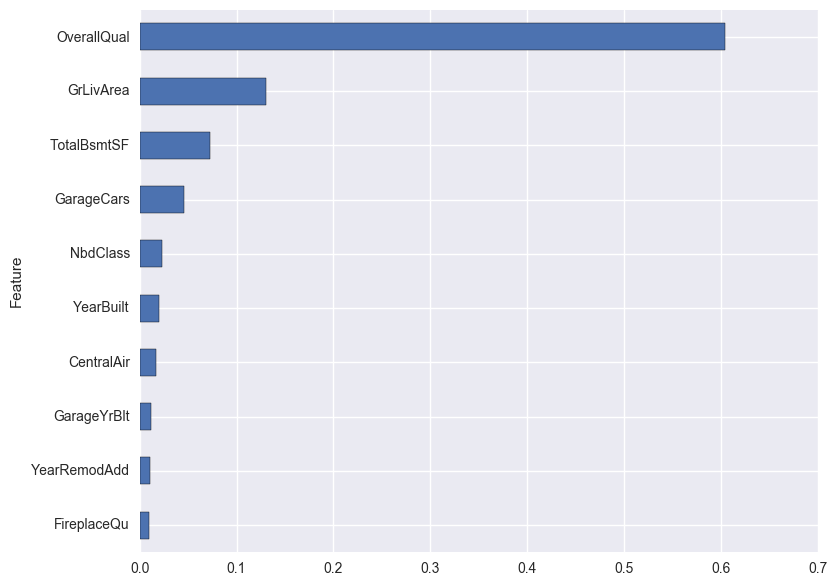

In [64]:
importances = pd.DataFrame({'Feature':trainX[use_features].columns, 'Importance':rf_best.feature_importances_})
importances = importances.sort_values('Importance',ascending=False).set_index('Feature')
importances[0:10].iloc[::-1].plot(kind='barh',legend=False)
plt.show()

So the model at least makes some logical sense. Let's see how it did:

In [65]:
rf.preds = np.exp(rf_best.predict(testX[use_features]))
solrf = pd.DataFrame({'Id':test['Id'], 'SalePrice':rf.preds})
solrf.to_csv("./Data/solrf2.csv", index=False)
solrf.head(3)

Id      SalePrice
0  1461  118535.691676
1  1462  143739.733478
2  1463  174677.994709

### 5.4 Random forest - full dataset
We'll try it with everything but the kitchen sink.

In [66]:
rf_all = RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_depth=7, random_state=17)
rf_all.fit(trainX, target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False, random_state=17,
           verbose=0, warm_start=False)

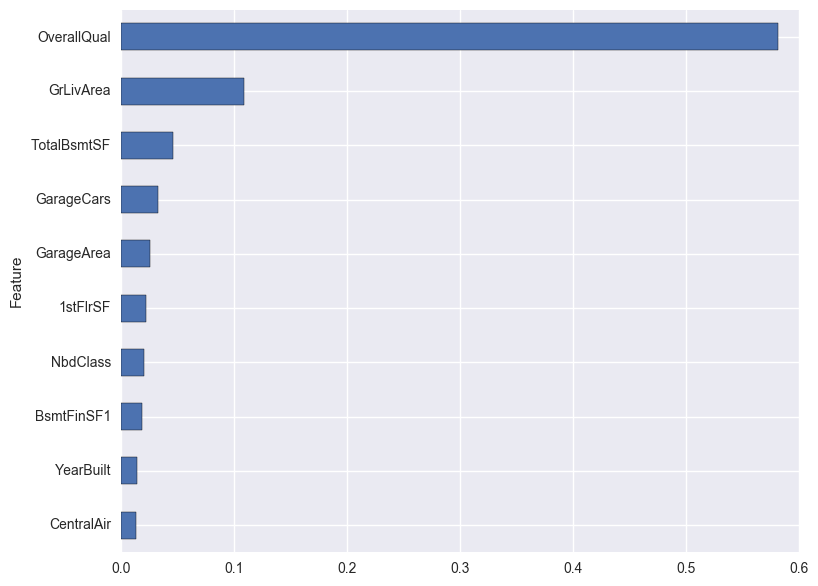

In [67]:
importances = pd.DataFrame({'Feature':trainX.columns, 'Importance':rf_all.feature_importances_})
importances = importances.sort_values('Importance',ascending=False).set_index('Feature')
importances[0:10].iloc[::-1].plot(kind='barh',legend=False)
plt.show()

In [68]:
rf.preds = np.exp(rf_all.predict(testX))
solrf = pd.DataFrame({'Id':test['Id'], 'SalePrice':rf.preds})
solrf.to_csv("./Data/solrf-full.csv", index=False)
solrf.head(3)

Id      SalePrice
0  1461  123926.943274
1  1462  148330.143627
2  1463  180258.788811

**Results:** The two random forest models scored at 0.15453 and 0.15129 - neither of which beat the "lasso" model. I put the lasso in quotes because it didn't actually squelch out any of the columns, but hey - if it's stupid but it works, it's not stupid.

### 5.5 XGBoost
This is the one the competition description said to try, so I'm trying it.

In [69]:
train_X = trainX.iloc[:,1:].as_matrix()
test_X = testX.iloc[:,1:].as_matrix()

In [70]:
gbm = xgb.XGBRegressor(max_depth=3, n_estimators=300, learning_rate=0.05).fit(train_X, target)

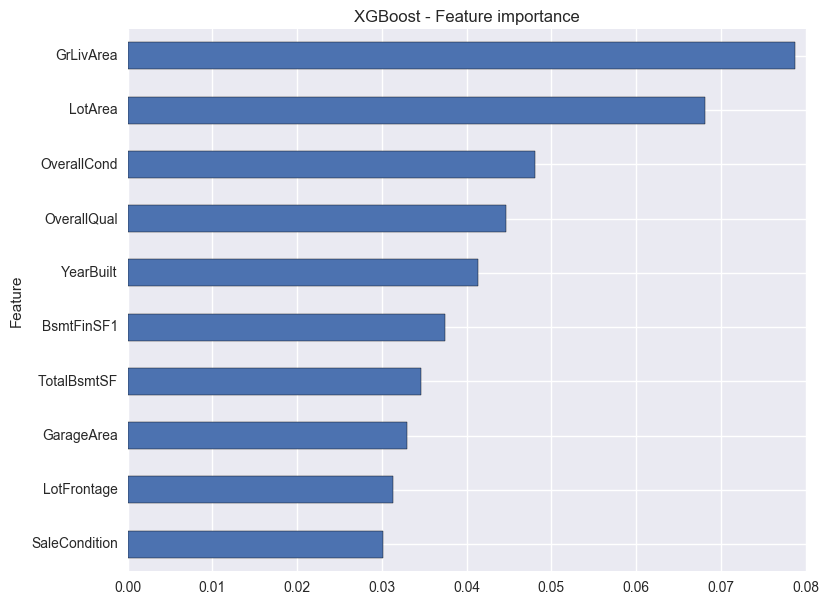

In [71]:
importances = pd.DataFrame({'Feature':trainX.iloc[:,1:].columns, 'Importance':gbm.feature_importances_})
importances = importances.sort_values('Importance',ascending=False).set_index('Feature')
importances[0:10].iloc[::-1].plot(kind='barh',legend=False)
plt.title("XGBoost - Feature importance")
plt.show()

In [72]:
xgb_preds = np.exp(gbm.predict(test_X))

In [73]:
solxgb = pd.DataFrame({'Id':test['Id'], 'SalePrice':xgb_preds})
solxgb.to_csv("./Data/solxgb.csv", index=False)
solxgb.head(3)

Id      SalePrice
0  1461  122297.914062
1  1462  158225.718750
2  1463  181202.828125

**Results:** This very vanilla model gave a score of 0.13175, good for 1,512th place as of this writing. I'm impressed. This is with no parameter tweaking at all, and very little feature engineering.

### 5.6 XGBoost with cross-validation
I'm going to use scikit's cross-validation features to see if I can get a better result by tweaking parameters.

In [76]:
param_grid = [
    {'max_depth': [1,2,3,4,5,6], 'n_estimators': [300,400,500,600,700], 'learning_rate':[0.025,0.05,0.075,0.1]}
]

In [79]:
xgb2 = model_selection.GridSearchCV(xgb.XGBRegressor(), param_grid, cv=10)
xgb2.fit(train_X, target)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'learning_rate': [0.025, 0.05, 0.075, 0.1], 'n_estimators': [300, 400, 500, 600, 700], 'max_depth': [1, 2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [82]:
xgb2.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 700}

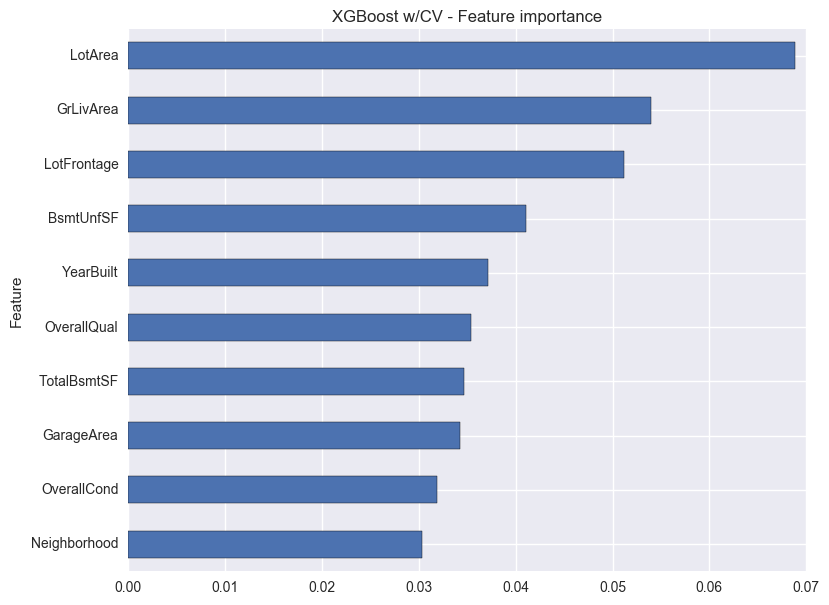

In [83]:
importances = pd.DataFrame({'Feature':trainX.iloc[:,1:].columns, 'Importance':xgb2.best_estimator_.feature_importances_})
importances = importances.sort_values('Importance',ascending=False).set_index('Feature')
importances[0:10].iloc[::-1].plot(kind='barh',legend=False)
plt.title("XGBoost w/CV - Feature importance")
plt.show()

In [85]:
xgb2_preds = np.exp(xgb2.predict(test_X))
solxgb2 = pd.DataFrame({'Id':test['Id'], 'SalePrice':xgb2_preds})
solxgb2.to_csv("./Data/solxgb2.csv", index=False)
solxgb2.head(3)

Id      SalePrice
0  1461  122374.218750
1  1462  160787.781250
2  1463  188264.859375

**Results:** This extra work bought me 1,424th place as of this writing, with a score of 0.12938.

In [86]:
xgb_best = xgb2.best_estimator_

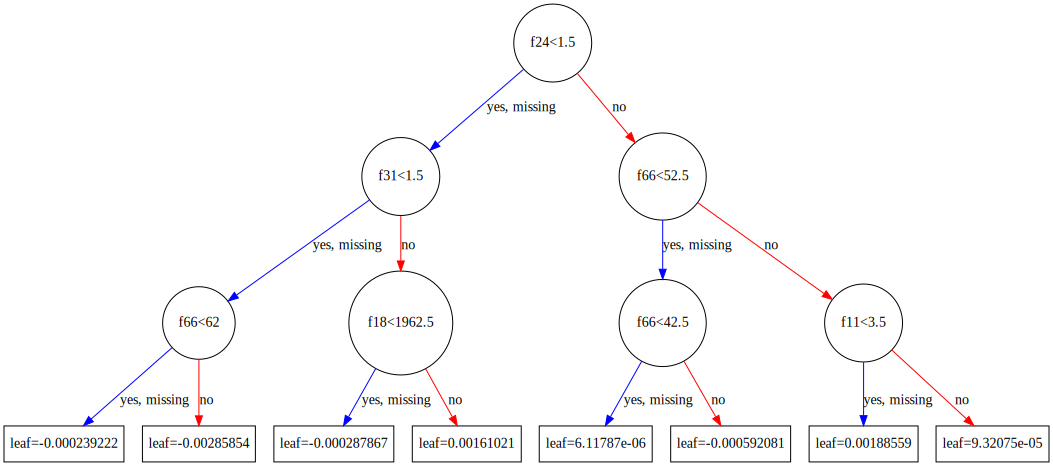

In [107]:
# Just wanna see a random tree
xgb.to_graphviz(xgb_best, num_trees=654)